# Análisis de texto | HW - Módulo 9 - Diplomado Data Science


**Contenido**

1. Introducción
2. Preparación
    * 2.1. Librerias
    * 2.2. Directorios
    * 2.3. Fechas
    * 2.4. Funciones
3. Data
4. EDA I - PDF
5. Transformaciones
6. EDA II - DataFrame
    * 6.1. Ley de Zipf
    * 6.2. Ley de Heaps
7. Modelos
    * 7.1. TF-IDF
    * 7.2. Clustering
    * 7.3. Sentiment Analysis + CatBoostRegressor


*Autor: Alexander Ulloa Opazo*

## 1. Introducción

A partir del archivo *“19900521.pdf”* correspondiente a la primera cuenta pública presidencial desde el retorno a la democracia, pronunciada el 25 de Mayo de 1990 por el entonces Presidente de la República Patricio Aylwin Azócar, se debe extraer su contenido con el fin de analizar aquellos elementos que mejor lo caracterizan.

Los pasos a completar son los siguientes: 

* Cargar archivo pdf en una lista, utilizando PdfReader u otra libreria similar
* Crear un data frame a partir de la lista anterior, donde cada fila corresponderá a cada página del discurso.
* Limpiar y normalizar el contenido mediante la función limpieza (considerar remover stopword y lematización de texto).
* Obtener los gráficos de la ley de **zipf** y **heaps**, interpretando si sus resultados se ajustan a la distribución esperada de cada ley.
* Representar el texto anterior tokenizado en una matriz TF-IDF ponderada (no binaria).
* Implementar un modelo de clustering con un máximo de 20 grupos, seleccionando la solución con la cantidad óptima de grupos. Se debe obtener los términos más frecuentes por cada grupo e interpretar los resultados.
* Implementar un análisis de sentimientos utilizando el léxico afin visto en clases. 

## 2. Preparación

### 2.1. Librerias

In [60]:
# Librerias
import pandas as pd 
import numpy as np
import re
import os
import random
import plotly.offline as py
import seaborn as sns
import sklearn.preprocessing
import sklearn.decomposition 
import matplotlib.pyplot as plt 
import sklearn.manifold
import matplotlib.cm as cm
import multidict as multidict
import ptitprince as pt
from kneed import KneeLocator
from matplotlib import pyplot 
from pylab import rcParams 
from math import sqrt 
from numpy import log 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud

import xgboost as xgb
from catboost import CatBoostRegressor,Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score
from lightgbm import LGBMRegressor
import optuna
import shap

import nltk 
import string
import stanza # Lemmatization -> https://stanfordnlp.github.io/stanza/lemma.html  https://es.stackoverflow.com/questions/341761/la-lematizaci%C3%B3n-de-spacy-en-castellano-no-es-muy-buena-conoc%C3%A9is-otros-paquetes
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import unidecode 
import unicodedata
import pdfplumber 
from PyPDF2 import PdfReader 

import pytz
import time
from datetime import datetime,timedelta, date

from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer 
from nltk import SnowballStemmer
from nltk.corpus import stopwords 
from nltk.tokenize.treebank import TreebankWordDetokenizer

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
# Libreria para lematizacion

# !pip install certifi (cuando ejecuto codigo en organizacion por problemas con proxy para descargar esto)
# import certifi
# certifi.where()

stanza.download('es')   
nlp = stanza.Pipeline('es')

2023-01-04 20:15:42 INFO: Downloading default packages for language: es (Spanish) ...
2023-01-04 20:15:44 INFO: File exists: C:\Users\arulloao\stanza_resources\es\default.zip
2023-01-04 20:15:48 INFO: Finished downloading models and saved to C:\Users\arulloao\stanza_resources.
2023-01-04 20:15:48 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-01-04 20:15:50 INFO: Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| depparse     | ancora   |
| sentiment    | tass2020 |
| constituency | combined |
| ner          | conll02  |

2023-01-04 20:15:50 INFO: Use device: cpu
2023-01-04 20:15:50 INFO: Loading: tokenize
2023-01-04 20:15:50 INFO: Loading: mwt
2023-01-04 20:15:50 INFO: Loading: pos
2023-01-04 20:15:50 INFO: Loading: lemma
2023-01-04 20:15:50 INFO: Loading: depparse
2023-01-04 20:15:50 INFO: Loading: sentiment
2023-01-04 20:15:51 INFO: Loading: constituency
2023-01-04 20:15:51 INFO: Loading: ner
2023-01-04 20:15:52 INFO: Done loading processors!


In [4]:
# Stop words y stemming
nltk.download('stopwords') 
stop_words = stopwords.words('spanish')
snowball = SnowballStemmer(language='spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arulloao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.2. Directorios

In [5]:
# Path
paths = dict()
paths["main"] = "C:/Users/ARULLOAO/OneDrive - Asociación Chilena de Seguridad/Desktop/Modulo 9/HW/"
paths["data"] = paths["main"] + "data/"

print(f'Main: {paths["main"]}')
print(f'Data: {paths["data"]}')

dir=os.chdir(paths["main"])

Main: C:/Users/ARULLOAO/OneDrive - Asociación Chilena de Seguridad/Desktop/Modulo 9/HW/
Data: C:/Users/ARULLOAO/OneDrive - Asociación Chilena de Seguridad/Desktop/Modulo 9/HW/data/


### 2.3. Fechas

In [6]:
# Dates
today = date.today()
today_file = datetime.now(pytz.timezone('America/Santiago')).strftime('%Y%m%d')
today_path = datetime.now(pytz.timezone('America/Santiago')).strftime('%Y/%m/%d')

print(f'Today: {today}')
print(f'Today as file: {today_file}')
print(f'Today as folder: {today_path}')

Today: 2023-01-04
Today as file: 20230104
Today as folder: 2023/01/04


### 2.4. Funciones

In [7]:
# EDA
def func_basic_eda(df):
    '''Función para obtener información exploratoria básica respecto a un data frame'''
    l=list()
    for var in df.columns:
        d=dict()
        d['variable']=var
        d['unique']=len(df[var].unique())
        d['dtype']=df[var].dtype
        d['nulls']=len(df[df[var].isna()])
        if d['dtype']!='object':
            d['median']=df[var].median()
            d['mean']=df[var].mean()
            d['std']=df[var].std()
            d['max']=df[var].max()
            d['min']=df[var].min()
            d['zeros']=len(df[df[var]==0])/len(df)
            d['mode']=df[var].mode()[0]
        
        else:
            d['mode']=df[var].mode()[0]

        d['example']=','.join([str(x) for x in random.choices(df[var].unique().tolist(), k=5)])
        l.append(d)
    
    df_eda=pd.DataFrame(l)
    df_eda['nulls_proportion']  = df_eda['nulls']/df.shape[0]
    df_eda['unique_proportion'] = df_eda['unique']/df.shape[0]

    df_eda = df_eda[['variable','dtype','unique','unique_proportion','nulls','nulls_proportion','median','mean','std','max','min','zeros','mode','example']]
    return df_eda

In [8]:
# Basic Plots

def func_get_frequency_dict_text(sentence):
    '''Función que permite obtener la frencuencia de una palabra a partir de un texto'''
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}
    for text in sentence.split(" "):
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def func_plot_wordcloud(text):
    '''Función para graficar una nube de las palabras más frecuentes a partir de un texto'''
    plt.figure(figsize=(8,8))
    wc = WordCloud(max_words=1000, margin=0, background_color='white',mode="RGBA", colormap='mako').generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.margins(x=0, y=0)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

def func_box_plot(df,var, pal='Blues', color='royalblue', size=(8, 4), xticks=None):
  '''
  Function which returns a box plot and density of a numeric variable
  Input 
      -df: Data frame
      -var: variable to analyze
  Output
      - Boxplot and density chart
  '''
  f, ax = plt.subplots(figsize=size)

  # Variables  
  dx = df[var]
  dy = None
  title = f'Distribution of the variable {var}'

  ax = pt.half_violinplot( x = dx, y = dy, data = df, width = .6, color=color, scale = "area", inner = None)
  ax = sns.stripplot( x = dx, y = dy, data = df, jitter=True, palette = pal, edgecolor = "white", size = 0.3 , zorder = 0)
  ax = sns.boxplot(x=dx, y=dy,data = df, width = .15, color = "black", zorder = 10, showcaps = True, fliersize=3,
                 boxprops = {'facecolor':'none', "zorder":10}, showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},saturation = 1)

  plt.title(title, fontsize=11)
  plt.xticks(ticks=xticks, rotation=0)
  plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='x', alpha=0.3)
  sns.set_style("whitegrid")

  plt.show()


def func_hist_plot(df ,var_x , color='royalblue' , rotation= 0, ylim=None, xlim=None, xticks=None, bins=10):
  '''
  Function which return a scatter plot from a variable of the dataframe. 
  Input 
      -df: Data frame
      -var_x: variable to analyze on the x axis
      -rotation: Rotation of the values on the axis

  Output
      -Hist plot
  '''
  # Variables  
  title = f'Distribution of the variable {var_x}'
  size = [8,4]


  plt.figure(figsize = size)
  sns.histplot(data=df, x=var_x, color=color, kde=True, bins=bins)
  plt.xlabel(var_x)
  plt.title(title, fontsize=11)
  plt.xticks(xticks, rotation=rotation)

  plt.axvline(x = df[var_x].mean(), color = 'red', label = 'mean')
  plt.axvline(x = df[var_x].median(), color = 'green', label = 'median')

  if ylim!=None or xlim!=None:
    plt.xlim(xlim)
    plt.ylim(ylim)

  plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both', alpha=0.3)
  plt.legend()
  sns.set_style("whitegrid")
  plt.show()

In [9]:
# Pre-procesamiento

def func_limpieza_texto_stemming(texto):
    '''Función que permite limpiar texto utilizando la técnica de stemming'''
    
    # Texto a minusculas
    texto_norm=texto.lower()
    # Remover espacios al final y al inicio de cada cadena
    texto_norm=texto_norm.strip()
    # Remover dobles espacios
    texto_norm=re.sub('\s',' ', texto_norm)
    # Normalizar el formato del texto a uno estandar por medio de unidecode
    texto_norm = unicodedata.normalize('NFD', texto_norm).encode('ascii', 'ignore').decode("utf-8")
    # Retener caracteres alfanumericos
    texto_norm=re.sub('[^A-Za-z]+', ' ', texto_norm)
    # Tokenizar texto: convertir en una lista una cadena
    texto_norm = word_tokenize(texto_norm)
    # Remover de terminos de largo 1
    texto_norm = [token for token in texto_norm if len(token) > 1]
    # Remover stopwords
    texto_norm = [word for word in texto_norm if not word in stop_words]
    # Stemming texto
    texto_norm=[snowball.stem(word) for word in texto_norm]
    # Exportar resultado final
    return(texto_norm)


def func_limpieza_texto_lemmatizacion(texto):
    '''Función que permite limpiar texto utilizando la técnica de lemmatization'''
    
    # Texto a minusculas
    texto_norm=texto.lower()
    # Remover espacios al final y al inicio de cada cadena
    texto_norm=texto_norm.strip()  
    # Remover dobles espacios
    texto_norm=re.sub('\s',' ', texto_norm)  
    # Normalizar el formato del texto a uno estandar por medio de unidecode
    texto_norm = unicodedata.normalize('NFD', texto_norm).encode('ascii', 'ignore').decode("utf-8")  
    # Retener caracteres alfanumericos
    texto_norm=re.sub('[^A-Za-z]+', ' ', texto_norm)  
    # Tokenizar texto: convertir en una lista una cadena
    texto_norm = word_tokenize(texto_norm)  
    # Remover de terminos de largo 1
    texto_norm = [token for token in texto_norm if len(token) > 1]  
    # Remover stopwords
    texto_norm = [word for word in texto_norm if not word in stop_words]  
    # Lematizar texto
    doc = nlp(' '.join(texto_norm))
    texto_norm = [word.lemma for sent in doc.sentences for word in sent.words]
    # Remover stopwords post lemmatizacion
    texto_norm = [word for word in texto_norm if not word in stop_words]
    # Exportar resultado final
    return(texto_norm)

In [10]:
# Clustering
def func_find_optimal_clusters(data, max_k):
    '''Función para generar clusters y encontrar el número óptimo de estos'''
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, 
                                   max_iter=100,
                                   init_size=1024, 
                                   batch_size=2048, 
                                   random_state=42).fit(data).inertia_)
        print(f'Fit {k} clusters')

    

    f, ax = plt.subplots(1, 1, figsize=(11, 6))
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Centros de clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE según centro de cluster')

    plt.grid(color='gray', linestyle='--', linewidth=0.3, axis='both', alpha=0.5)

    # Obtener numero óptimo de clusters
    kn = KneeLocator(iters, sse, curve='convex', direction='decreasing')
    print(f'Número óptimo de clústers: {kn.knee}') 

    try:
        plt.text(0.8, 0.9, f'N° clusters óptimo: {kn.knee}', transform=plt.gca().transAxes, fontdict={'fontsize':11})
        plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red')
    except:
        print('No se ha encontrado un número óptimo de clusters')

    plt.show()

    return list(iters), sse
    

def func_plot_tsne_pca(data, labels):
    '''Función que permite graficar un análisis de PCA (Principal Component Analysis) y TSNE (t-distributed stochastic neighbor embedding) '''
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('Grafico PCA')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('Grafico TSNE')
    

def func_get_top_keywords_cluster(data, clusters, labels, n_terms):
    '''Función para obtener las n top palabras claves por cluster
    '''
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    dic_clusters = {}

    for i,r in df.iterrows():
        # print('\nCluster {}'.format(i+1))
        # print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

        dic_clusters[f'Cluster_{i+1}'] = [labels[t] for t in np.argsort(r)[-n_terms:]]
            
    return pd.DataFrame(dic_clusters)

In [62]:
# Modeling
def func_models_metrics(expected_y, predicted_y, model='XGBoost - Basic parameters'):
    '''Function which returns some basic regression metrics from a model's predicted values'''

    metrics = dict()

    metrics['model']    = [model]
    metrics['rmse']     = [mean_squared_error(expected_y,predicted_y, squared=False)]
    metrics['r2']       = [r2_score(expected_y,predicted_y)]
    metrics['mae']      = [mean_absolute_error(expected_y, predicted_y)]
    metrics['mse']      = [mean_squared_error(expected_y, predicted_y)]
    # metrics['mae_log']  = [mean_squared_log_error(expected_y, predicted_y)]

    df_metrics = pd.DataFrame(metrics, columns=metrics.keys())
    
    return df_metrics

## 3. Data

In [12]:
# Importando el archivo pdf
pdf_file = pdfplumber.open('data/19900521.pdf')
pdf_file

## 4. EDA I - PDF

In [13]:
# Revisando la metadata
pdf_file.metadata

{'CreationDate': 'D:20040427152331',
 'Producer': 'Acrobat Distiller 4.0 for Windows',
 'ModDate': "D:20040427152400-04'00'"}

In [14]:
# Número de paginas
len(pdf_file.pages)

81

In [15]:
# Extracto de la primera página
pdf_file.pages[0].extract_text()

'1\nLegislatura 320ª, Ordinaria\nSesión del Congreso Pleno, en lunes 21 de mayo de 1990\nIV. MENSAJE PRESIDENCIAL\nEl señor VALDÉS (Presidente).- Su Excelencia el\nPresidente de la República concurre a esta sesión del\nCongreso Pleno para dar cuenta al país del estado\nadministrativo y político de la nación, de acuerdo con lo\nestablecido en el inciso final del artículo 24 de la\nConstitución Política del Estado.\nCon tal propósito, tiene la palabra Su Excelencia el\nPresidente de la República.\nEl señor AYLWIN (Presidente de la República).-\nConciudadanos del Senado y de la Cámara de Diputados:\nCumplo el deber que la Constitución impone al Presidente\nde la República de dar cuenta al país, al menos una vez al\naño, “del estado administrativo y político de la nación”.\nAunque el texto constitucional vigente no prescribe ante\nquién ha de rendirse esta cuenta ni la oportunidad de\nhacerlo, pienso que lo más adecuado es restablecer la vieja\ntradición histórica, que expresamente consagr

In [16]:
# Extracto de la última página
pdf_file.pages[-1].extract_text()

'81\nAhora tenemos una nueva oportunidad, y la razón nos\naconseja sacar lecciones de la experiencia y saber\naprovecharlas.\nEn los albores de la patria, en 1911, un colega vuestro\ndecía estas palabras: “Las naciones tienen recursos en sí\nmismas; pueden salvarse por la sabiduría y la prudencia”.\nCamilo Henríquez tenía razón. Quizás sean esas dos virtudes\nla savia más rica de nuestra tradición histórica.\nEl Gobierno, el Congreso Nacional, los Tribunales de\nJusticia, los partidos políticos, las organizaciones\nsociales, tenemos en esta etapa una responsabilidad\nhistórica: estar a la altura de lo que Chile tiene derecho a\nreclamarnos y nuestro pueblo espera de nosotros. Lo\nconseguiremos en la medida misma en que la sabiduría y la\nprudencia -y no las pasiones, ni los egoísmos, ni los\nimpulsos vehementes- presidan nuestra conducta.\nDe nosotros depende: de todos los chilenos.\n¡Que Dios nos ayude!\n-(Aplausos).\nEl señor VALDÉS (Presidente).- En conformidad a lo\ndispuesto en el

In [17]:
# Concatenación de todo el texto
text=''
for page in range(0,len(pdf_file.pages)):
    text+=pdf_file.pages[page].extract_text()

# Tamaño del corpus total 
len(text)

137956

In [18]:
# Extracto corpus total
print('Top 200')
text[:200]

Top 200


'1\nLegislatura 320ª, Ordinaria\nSesión del Congreso Pleno, en lunes 21 de mayo de 1990\nIV. MENSAJE PRESIDENCIAL\nEl señor VALDÉS (Presidente).- Su Excelencia el\nPresidente de la República concurre a esta'

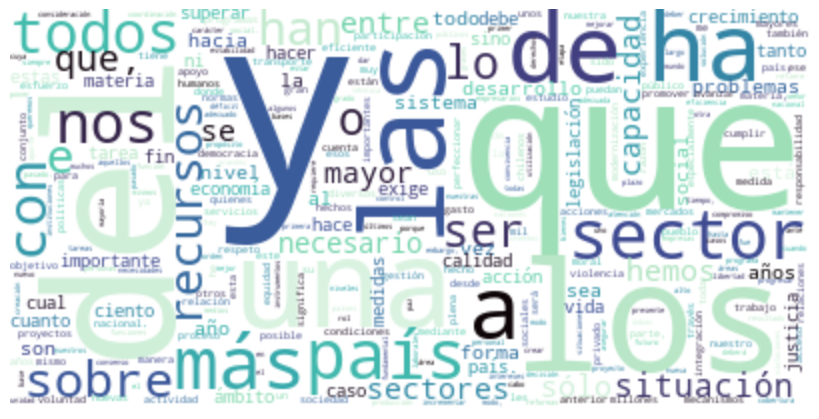

In [19]:
# Wordcloud del corpus total sin filtrar (con stopwords incluidos)
func_plot_wordcloud(func_get_frequency_dict_text(text))

## 5. Transformaciones

In [20]:
# Agrupando el contenido total del PDF en una lista, donde cada item corresponde a una página.
## Para este caso solo basta un ciclo "for", pero de igual forma se podria haber echo mediante exrpesiones regulares (regex)

list_paginas_discurso = []
for i in range(len(pdf_file.pages)):
    list_paginas_discurso.append(pdf_file.pages[i].extract_text())

len(list_paginas_discurso)

81

In [21]:
# Revisando las primeras 2 paginas
list_paginas_discurso[:2]

['1\nLegislatura 320ª, Ordinaria\nSesión del Congreso Pleno, en lunes 21 de mayo de 1990\nIV. MENSAJE PRESIDENCIAL\nEl señor VALDÉS (Presidente).- Su Excelencia el\nPresidente de la República concurre a esta sesión del\nCongreso Pleno para dar cuenta al país del estado\nadministrativo y político de la nación, de acuerdo con lo\nestablecido en el inciso final del artículo 24 de la\nConstitución Política del Estado.\nCon tal propósito, tiene la palabra Su Excelencia el\nPresidente de la República.\nEl señor AYLWIN (Presidente de la República).-\nConciudadanos del Senado y de la Cámara de Diputados:\nCumplo el deber que la Constitución impone al Presidente\nde la República de dar cuenta al país, al menos una vez al\naño, “del estado administrativo y político de la nación”.\nAunque el texto constitucional vigente no prescribe ante\nquién ha de rendirse esta cuenta ni la oportunidad de\nhacerlo, pienso que lo más adecuado es restablecer la vieja\ntradición histórica, que expresamente consag

In [22]:
# Revisando las últimas 2 paginas
list_paginas_discurso[-2:]

['80\nanexos de cada Ministerio, los señores Parlamentarios\nencontrarán los antecedentes, cuadros y cifras explicativas\nde esta cuenta a la Nación.\nComo es fácil advertir, en cuanto a la situación en que\nrecibimos la Administración y el Gobierno, me he limitado a\nexponer en cada rubro los antecedentes fundamentales,\nevitando detalles o comentarios que habrían extendido aún más\nesta exposición y pudieran herir susceptibilidades. Como dije\nal comienzo, me interesa el futuro y no el pasado. Es tanto y\ntan importante y hermoso el quehacer que tenemos por delante,\nque sería malgastar nuestro tiempo detenernos a escudriñar el\npasado. Esa será tarea de la historia.\nVivimos una etapa trascendental. El pueblo de Chile ha\nvuelto a la democracia con alegría y esperanza. La gente está\ncontenta de vivir en libertad. Cada cual espera ser respetado\nen su dignidad de persona, cualesquiera que sean sus\ncreencias, ideas o situación social. La gente quiere vivir\nlibre de temor y de toda 

In [23]:
# Creando un DataFrame a partir de la lista anterior
df_paginas_discurso = pd.DataFrame(list_paginas_discurso, columns=['raw'])

print(f'Shape: {df_paginas_discurso.shape}')

df_paginas_discurso.head()

Shape: (81, 1)


,raw
0,"1\nLegislatura 320ª, Ordinaria\nSesión del Con..."
1,"2\nDesde hace setenta días, los chilenos vivim..."
2,"3\nmenos cierto que esos hechos, cuya frecuenc..."
3,4\nJusto es reconocer que esta nueva y promiso...
4,5\npor diversos partidos políticos coincidenci...


In [24]:
# Extrayendo el número de página
df_paginas_discurso['numero_pagina'] = df_paginas_discurso['raw'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
df_paginas_discurso = df_paginas_discurso[['numero_pagina','raw']]

print(f'Shape: {df_paginas_discurso.shape}')

display(df_paginas_discurso)

Shape: (81, 2)


,numero_pagina,raw
0,1,"1\nLegislatura 320ª, Ordinaria\nSesión del Con..."
1,2,"2\nDesde hace setenta días, los chilenos vivim..."
2,3,"3\nmenos cierto que esos hechos, cuya frecuenc..."
3,4,4\nJusto es reconocer que esta nueva y promiso...
4,5,5\npor diversos partidos políticos coincidenci...
...,...,...
76,77,"77\nSistema Económico Latinoamericano, SELA, d..."
77,78,78\neliminándose “órdenes de mercado” y otras ...
78,79,79\nmismo día 11 de marzo hemos reanudado las ...
79,80,"80\nanexos de cada Ministerio, los señores Par..."


In [25]:
%%time
# Agregando columna con texto pre-procesado (15 min aprox)
df_paginas_discurso_lemma = df_paginas_discurso.copy()

df_paginas_discurso_lemma['clean_lemma'] = df_paginas_discurso_lemma['raw'].apply(lambda x: func_limpieza_texto_lemmatizacion(x))

print(f'Shape: {df_paginas_discurso_lemma.shape}')

display(df_paginas_discurso_lemma)

Shape: (81, 3)


,numero_pagina,raw,clean_lemma
0,1,"1\nLegislatura 320ª, Ordinaria\nSesión del Con...","[legislatura, ordinario, sesion, congreso, ple..."
1,2,"2\nDesde hace setenta días, los chilenos vivim...","[hacer, setenta, dia, chileno, vivir, nuevamen..."
2,3,"3\nmenos cierto que esos hechos, cuya frecuenc...","[menos, cierto, hecho, cuyo, frecuencia, dismi..."
3,4,4\nJusto es reconocer que esta nueva y promiso...,"[justo, reconocer, nuevo, promisorio, realidad..."
4,5,5\npor diversos partidos políticos coincidenci...,"[diverso, partido, politico, coincidencia, imp..."
...,...,...,...
76,77,"77\nSistema Económico Latinoamericano, SELA, d...","[sistema, economico, latinoamericano, selo, di..."
77,78,78\neliminándose “órdenes de mercado” y otras ...,"[eliminar, órden, mercado, medida, proteccioni..."
78,79,79\nmismo día 11 de marzo hemos reanudado las ...,"[mismo, dia, marzo, reanudado, relación, diplo..."
79,80,"80\nanexos de cada Ministerio, los señores Par...","[anexo, cada, ministerio, senor, parlamentario..."


Wall time: 12min 53s


In [26]:
# Agregando columna con texto pre-procesado unido como string (detokenize)
detokenizer=TreebankWordDetokenizer()
df_paginas_discurso_lemma['clean_lemma_detok']=df_paginas_discurso_lemma['clean_lemma'].map(lambda x: detokenizer.detokenize(x))

print(f'Shape: {df_paginas_discurso_lemma.shape}')

display(df_paginas_discurso_lemma)

Shape: (81, 4)


,numero_pagina,raw,clean_lemma,clean_lemma_detok
0,1,"1\nLegislatura 320ª, Ordinaria\nSesión del Con...","[legislatura, ordinario, sesion, congreso, ple...",legislatura ordinario sesion congreso pleno lu...
1,2,"2\nDesde hace setenta días, los chilenos vivim...","[hacer, setenta, dia, chileno, vivir, nuevamen...",hacer setenta dia chileno vivir nuevamente baj...
2,3,"3\nmenos cierto que esos hechos, cuya frecuenc...","[menos, cierto, hecho, cuyo, frecuencia, dismi...",menos cierto hecho cuyo frecuencia disminuir r...
3,4,4\nJusto es reconocer que esta nueva y promiso...,"[justo, reconocer, nuevo, promisorio, realidad...",justo reconocer nuevo promisorio realidad ser ...
4,5,5\npor diversos partidos políticos coincidenci...,"[diverso, partido, politico, coincidencia, imp...",diverso partido politico coincidencia importan...
...,...,...,...,...
76,77,"77\nSistema Económico Latinoamericano, SELA, d...","[sistema, economico, latinoamericano, selo, di...",sistema economico latinoamericano selo dispone...
77,78,78\neliminándose “órdenes de mercado” y otras ...,"[eliminar, órden, mercado, medida, proteccioni...",eliminar órden mercado medida proteccionista a...
78,79,79\nmismo día 11 de marzo hemos reanudado las ...,"[mismo, dia, marzo, reanudado, relación, diplo...",mismo dia marzo reanudado relación diplomatico...
79,80,"80\nanexos de cada Ministerio, los señores Par...","[anexo, cada, ministerio, senor, parlamentario...",anexo cada ministerio senor parlamentario enco...


In [103]:
# Ejemplo de una pagina lemmatizada (pagina 3)
df_paginas_discurso_lemma[df_paginas_discurso_lemma['numero_pagina']==3]['clean_lemma_detok'][2]

'menos cierto hecho cuyo frecuencia disminuir relacion epoco pasado aun reciente provocar cada dia mayor repudio sector poblacion grupusculo perpetrar cualquiera signo ir quedar cada vez mas aislado ninguno razon justificar conciencia publicar suscitir repulsa propio delincuente disminuir gravedad hecho cuyo erradicacion castigo requerir solo accion organismo policial judicial sino tambien cooperacion responsable pedagogico nadie poder seriamente negar chile vivir etapa promisorio reencuentro nacional logico guerra dividir chileno amigo enemigo ser superar logico paz reconocer compatriota cualesquiera diferencia duro experiencia ano confrontacion sufrimiento ensenado superar caduco prejuicio intransigencio ideologico respetar explicable discrepancia procurar comprender mutuamente admitir natural diversidad poder ser obstaculo insuperable unidad esencial chileno modo aunque material cambiar chileno comun vivir libertad vida mas pleno mas segura miedo pasado alegrio esperanza saber respe

In [27]:
# Obteniendo el largo de los textos tanto raw como clean
df_paginas_discurso_preprocessed = df_paginas_discurso_lemma.copy()

df_paginas_discurso_preprocessed['len_raw'] = df_paginas_discurso_preprocessed['raw'].apply(lambda x: len(x))
df_paginas_discurso_preprocessed['len_clean_lemma_detok'] = df_paginas_discurso_preprocessed['clean_lemma_detok'].apply(lambda x: len(x))
df_paginas_discurso_preprocessed['len_diff'] =  df_paginas_discurso_preprocessed['len_raw'] - df_paginas_discurso_preprocessed['len_clean_lemma_detok']

df_paginas_discurso_preprocessed['numero_pagina'] = df_paginas_discurso_preprocessed['numero_pagina'].astype(str)

print(f'Shape: {df_paginas_discurso_preprocessed.shape}')

display(df_paginas_discurso_preprocessed)

Shape: (81, 7)


,numero_pagina,raw,clean_lemma,clean_lemma_detok,len_raw,len_clean_lemma_detok,len_diff
0,1,"1\nLegislatura 320ª, Ordinaria\nSesión del Con...","[legislatura, ordinario, sesion, congreso, ple...",legislatura ordinario sesion congreso pleno lu...,1321,912,409
1,2,"2\nDesde hace setenta días, los chilenos vivim...","[hacer, setenta, dia, chileno, vivir, nuevamen...",hacer setenta dia chileno vivir nuevamente baj...,1760,1161,599
2,3,"3\nmenos cierto que esos hechos, cuya frecuenc...","[menos, cierto, hecho, cuyo, frecuencia, dismi...",menos cierto hecho cuyo frecuencia disminuir r...,1622,1123,499
3,4,4\nJusto es reconocer que esta nueva y promiso...,"[justo, reconocer, nuevo, promisorio, realidad...",justo reconocer nuevo promisorio realidad ser ...,1798,1199,599
4,5,5\npor diversos partidos políticos coincidenci...,"[diverso, partido, politico, coincidencia, imp...",diverso partido politico coincidencia importan...,1846,1285,561
...,...,...,...,...,...,...,...
76,77,"77\nSistema Económico Latinoamericano, SELA, d...","[sistema, economico, latinoamericano, selo, di...",sistema economico latinoamericano selo dispone...,1668,1164,504
77,78,78\neliminándose “órdenes de mercado” y otras ...,"[eliminar, órden, mercado, medida, proteccioni...",eliminar órden mercado medida proteccionista a...,1818,1270,548
78,79,79\nmismo día 11 de marzo hemos reanudado las ...,"[mismo, dia, marzo, reanudado, relación, diplo...",mismo dia marzo reanudado relación diplomatico...,1826,1248,578
79,80,"80\nanexos de cada Ministerio, los señores Par...","[anexo, cada, ministerio, senor, parlamentario...",anexo cada ministerio senor parlamentario enco...,1724,1189,535


In [28]:
# Export data frame pre-procesado
df_paginas_discurso_preprocessed.to_parquet('data/df_paginas_discurso_preprocessed.parquet')

## 6. EDA II - DataFrame

In [29]:
# Basic EDA
df_basic_eda = func_basic_eda(df_paginas_discurso_preprocessed.drop('clean_lemma',axis=1))
df_basic_eda

,variable,dtype,unique,unique_proportion,nulls,nulls_proportion,median,mean,std,max,min,zeros,mode,example
0,numero_pagina,object,81,1.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,"69,44,60,41,9"
1,raw,object,81,1.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,"1\nLegislatura 320ª, Ordinaria\nSesión del Con...","77\nSistema Económico Latinoamericano, SELA, d..."
2,clean_lemma_detok,object,81,1.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,ademas dado gastar conservacion millón dolar a...,querer tambien asegurar autonomia empresa resp...
3,len_raw,int64,70,0.864198,0,0.0,1720.0,1703.160494,125.537490,1892.0,1193.0,0.0,1784,"1643,1663,1768,1833,1700"
4,len_clean_lemma_detok,int64,73,0.901235,0,0.0,1189.0,1169.950617,98.705610,1353.0,749.0,0.0,1095,"1149,1329,1122,1197,1255"
5,len_diff,int64,65,0.802469,0,0.0,521.0,533.209877,58.520876,708.0,409.0,0.0,455,"551,567,517,577,444"


In [30]:
# Basic EDA
df_paginas_discurso_preprocessed.describe()

,len_raw,len_clean_lemma_detok,len_diff
count,81.000000,81.000000,81.000000
mean,1703.160494,1169.950617,533.209877
std,125.537490,98.705610,58.520876
min,1193.000000,749.000000,409.000000
25%,1655.000000,1138.000000,494.000000
50%,1720.000000,1189.000000,521.000000
75%,1784.000000,1231.000000,563.000000
max,1892.000000,1353.000000,708.000000


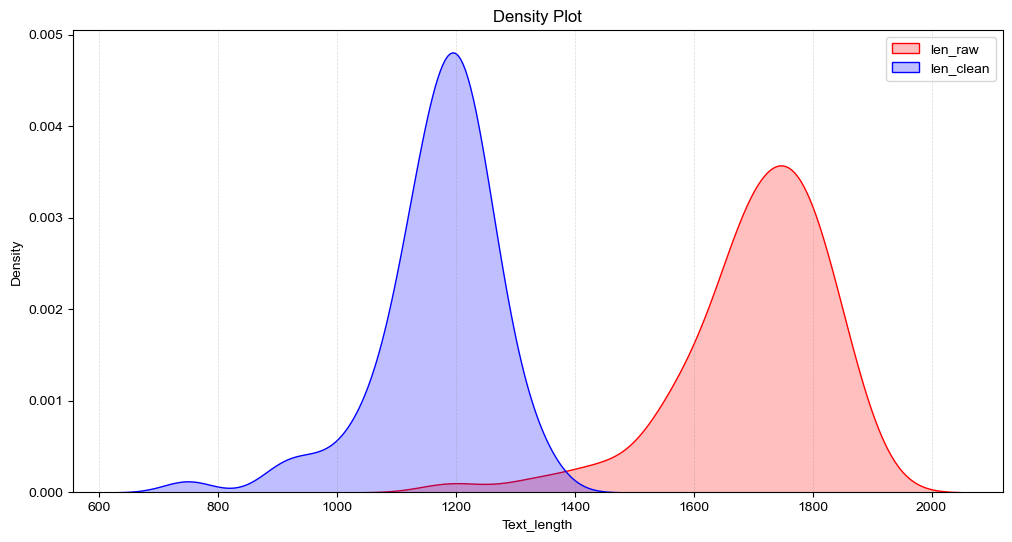

In [31]:
# Distribucion de los largos de textos raw y clean
plt.figure(figsize=(12,6))
sns.kdeplot(df_paginas_discurso_preprocessed['len_raw'], color="red", shade=True , label = 'len_raw')
sns.kdeplot(df_paginas_discurso_preprocessed['len_clean_lemma_detok'], color="blue", shade=True, label = 'len_clean')

plt.title('Density Plot')
plt.xlabel('Text_length')
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='x', alpha=0.3)
plt.legend()
sns.set_style("whitegrid")
plt.show()

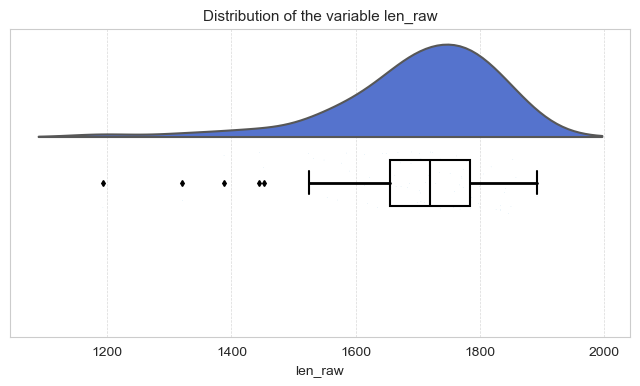

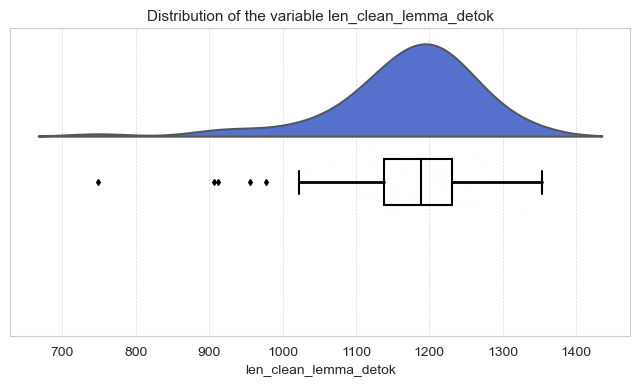

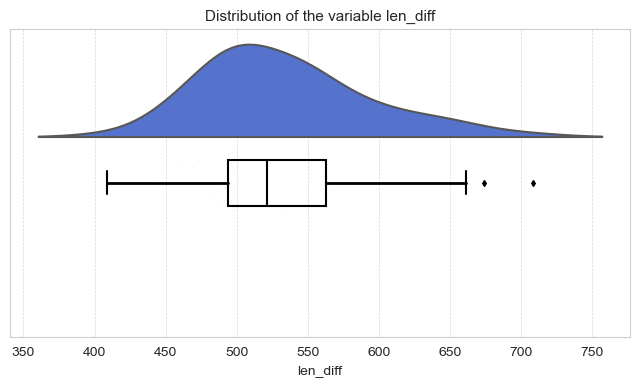

In [32]:
# Boxplot
for col in ['len_raw', 'len_clean_lemma_detok', 'len_diff']:
    func_box_plot(df = df_paginas_discurso_preprocessed, var=col)

Length: 95090


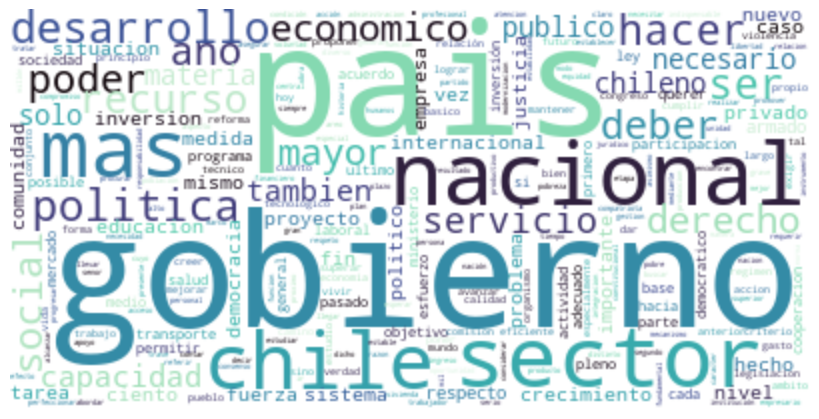

In [33]:
# Wordcloud del corpus total limpio
text_clean = str(list(df_paginas_discurso_preprocessed['clean_lemma_detok']))

print(f'Length: {len(text_clean)}')

func_plot_wordcloud(func_get_frequency_dict_text(text_clean))

### 6.1. Ley de Zipf

In [34]:
# Ajustando el data frame para obtener insights a partir de las leyes
df_leyes = df_paginas_discurso_preprocessed.copy()

# Explode 'clean_lemma (transform each element of a list-like to a row, replicating index values.)
doc_term = df_leyes.explode(column= 'clean_lemma')

 # Remover columnas que no utilizaremos
doc_term=doc_term.drop(columns=['raw', 'clean_lemma_detok', 'len_raw', 'len_clean_lemma_detok', 'len_diff'])

# Renombrar la columna de termino
doc_term=doc_term.rename(columns={'clean_lemma':'termino'})

print(f'Shape: {doc_term.shape}')
display(doc_term)

Shape: (10938, 2)


,numero_pagina,termino
0,1,legislatura
0,1,ordinario
0,1,sesion
0,1,congreso
0,1,pleno
...,...,...
80,81,manuel
80,81,ocano
80,81,vergaro
80,81,jefe


In [35]:
# Vocabulario a partir del data frame anterior
vocabulario=doc_term.groupby(['termino']).count().sort_values(by='numero_pagina', ascending=False).reset_index()

# Renombrar para identificar frecuencia del termino
vocabulario  = vocabulario.rename(columns={'numero_pagina':'frecuencia'})

# Agregar columna con el ranking
vocabulario['ranking']=vocabulario.index+1

# Generar la frecuencia estimada segun formula de la ley de zipf
vocabulario['frecuencia_estimada']=vocabulario.frecuencia[0]/(vocabulario.ranking**2)

print(f'Shape: {vocabulario.shape}')
display(vocabulario)

Shape: (2845, 4)


,termino,frecuencia,ranking,frecuencia_estimada
0,gobierno,99,1,99.000000
1,nacional,92,2,24.750000
2,pais,90,3,11.000000
3,sector,87,4,6.187500
4,mas,75,5,3.960000
...,...,...,...,...
2840,flete,1,2841,0.000012
2841,fisco,1,2842,0.000012
2842,fiscalizar,1,2843,0.000012
2843,firmante,1,2844,0.000012


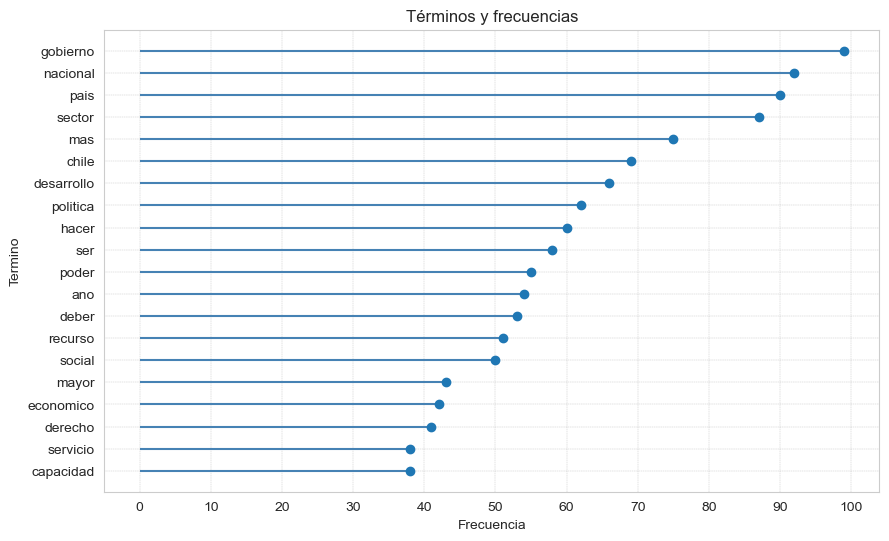

In [36]:
# Plot frecuencias
rango=range(1,len(vocabulario.head(20)[::-1].index)+1)

plt.figure(figsize = (10,6))
plt.hlines(y=rango, xmin=0, xmax=vocabulario['frecuencia'].head(20)[::-1], color='steelblue')
plt.plot(vocabulario['frecuencia'].head(20)[::-1], rango, "o")

plt.xticks(range(0,101,10))
plt.yticks(rango, vocabulario['termino'].head(20)[::-1])
plt.title("Términos y frecuencias")
plt.xlabel('Frecuencia')
plt.ylabel('Termino')
plt.grid(color='gray', linestyle='--', linewidth=0.3, axis='both', alpha=0.5)

plt.show()

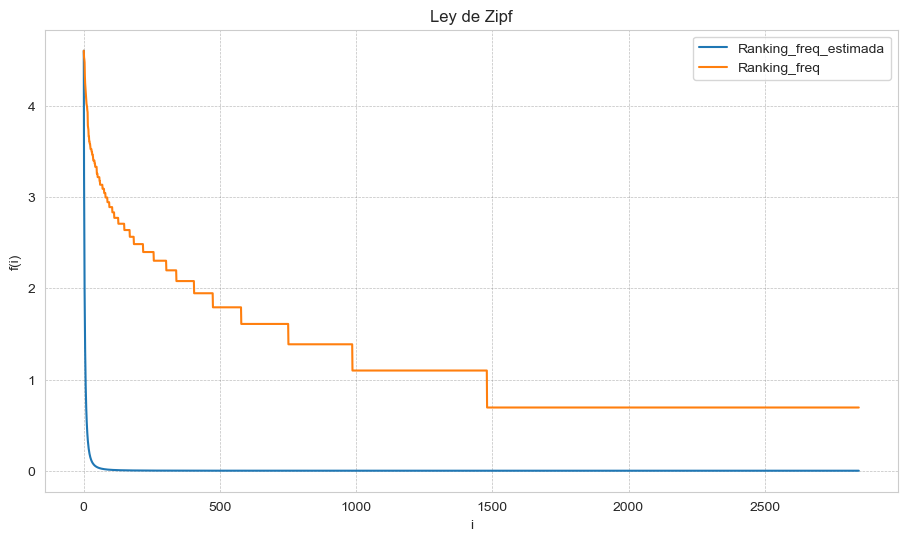

In [37]:
# Ley de Zipf
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(vocabulario.ranking, np.log(vocabulario.frecuencia_estimada+1), label='Ranking_freq_estimada')
ax.plot(vocabulario.ranking, np.log(vocabulario.frecuencia+1), label='Ranking_freq')

# Agregamos titulo y nombres en los ejes
plt.title('Ley de Zipf')
plt.xlabel("i")
plt.ylabel("f(i)")
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both', alpha=0.5)
plt.show()

**Interpretación**

La ley de Zipf correspode a una ley de distribución en la que la frecuencia de una palabra en un texto se inversamente proporcional a su rango de frecuencia en el texto. En otras palabras, la palabra más comúnmente utilizada en un texto ocurrirá con mayor frecuencia que cualquier otra palabra, y la segunda palabra más comúnmente utilizada ocurrirá con una frecuencia menor, y así sucesivamente. A partir de esto es posible ver como evoluciona la frecuencia de las palabras en función de su ranking.

Por medio de esta ley se puede ver que el texto carece de riqueza lingüistica, dado que muy pocas palabras concentran gran parte de la frecuencia (tales como gobierno, nacional, pais, sector, etc), por lo que la aplicacion de métodos clásicos de procesamiento de textos para extraer patrones y conocimiento no hará mucha diferencia respecto al sentido común. 

Si observamos el gráfico nuevamente vemos que la palabra "gobierno" aparece con mucha mayor frecuencia que otras palabras, por lo que podemos inferir que el gobierno es un tema importante en estos documentos y que corresponde a un término clave para entender el contenido general (dado que estamos analizando un discurso politico de un presidente en el marco de una cuenta pública)

### 6.2. Ley de Heaps

In [38]:
# Adaptando data frame para la ley de heaps

# Count de terminos totales
total_terminos_por_pagina=pd.DataFrame(doc_term.groupby(['numero_pagina'])['termino'].count())
total_terminos_por_pagina=total_terminos_por_pagina.rename(columns={'termino':'terminos_totales'})

# Count de terminos unicos
distint_termino_por_pagina=pd.DataFrame(doc_term.groupby(['numero_pagina'])['termino'].nunique())
distint_termino_por_pagina=distint_termino_por_pagina.rename(columns={'termino':'terminos_distintos'})

# Concat
vocabulario_por_pagina=pd.concat([total_terminos_por_pagina,distint_termino_por_pagina], axis=1).sort_values(by='terminos_distintos', ascending=True).reset_index()

# Parametros para la ley de Heaps
K=30
beta=0.8
vocabulario_por_pagina['V']=K*(vocabulario_por_pagina.terminos_totales**beta)

print(f'Shape: {vocabulario_por_pagina.shape}')
display(vocabulario_por_pagina)

Shape: (81, 4)


,numero_pagina,terminos_totales,terminos_distintos,V
0,1,108,79,1270.165344
1,81,92,85,1117.252967
2,22,132,90,1491.352820
3,16,110,90,1288.948017
4,10,112,91,1307.662510
...,...,...,...,...
76,12,145,123,1607.739406
77,47,159,124,1730.768387
78,69,142,126,1581.073029
79,32,141,126,1572.159285


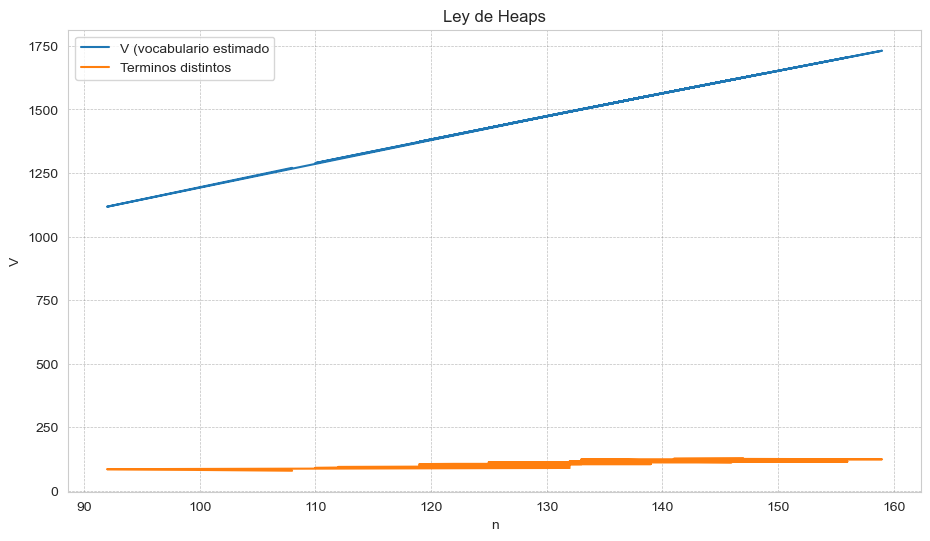

In [105]:
# Ley de Heaps
fig, ax = plt.subplots(figsize=(11, 6))
ax.plot(vocabulario_por_pagina.terminos_totales, vocabulario_por_pagina.V, label='V (vocabulario estimado')
ax.plot(vocabulario_por_pagina.terminos_totales, vocabulario_por_pagina.terminos_distintos, label='Terminos distintos')

plt.title('Ley de Heaps')
plt.xlabel("n")
plt.ylabel("V")
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='both', alpha=0.5)
plt.legend()
plt.show()

**Interpretación**

La ley de Heaps es similar a la ley de Zipf en que ambas son leyes de distribución que se aplican a la frecuencia de palabras en un texto. La ley de Heaps establece que la frecuencia de una palabra en un texto es inversamente proporcional a su rango de frecuencia en el texto, pero con una mayor flexibilidad en términos de cómo se ajusta a los datos. En otras palabras, la ley de Heaps permite una mayor variedad de patrones de distribución en comparación con la ley de Zipf, lo que significa que la frecuencia de las palabras en un texto puede no seguir exactamente un patrón de línea recta.

A partir del gráfico anterior se puede observar claramente que la relación entre el tamaño del texto (cantidad total que se mencionan) y la cantidad de palabras distintas es lineal, y no concava como se esperaría, lo que significa que el texto no se ajusta a la distribución esperada para obtener resultados significativos a partir de la aplicación de métodos clásicos de procesamiento de textos, dado que en el contexto matricial como el producido por un TF-IDF, exista mucha escacez de información. 

## 7. Modelos

### 7.1. TF-IDF

In [40]:
# TF-IDF
df_tfidf_raw = df_paginas_discurso_preprocessed.copy()

def identity_tokenizer(text):
    return text

# Instance
tfidf_vect = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False,
                             use_idf=True,
                             binary=False,
                             ngram_range=(1,2) # unigrams and bigrams
                             ) 

# Fit
tfidf_vect.fit(df_tfidf_raw['clean_lemma'])

# Transform
tfidf_data = tfidf_vect.transform(df_tfidf_raw['clean_lemma'])

# Data frame
df_tfidf =pd.DataFrame(tfidf_data.toarray(), columns=tfidf_vect.get_feature_names())

print(f'Shape: {df_tfidf.shape}')
display(df_tfidf)

Shape: (81, 12663)


,abarcar,abarcar mil,abarcar sector,abastecer,abastecer demanda,abastecimiento,abastecimiento hecho,abierto,abierto chile,abierto desarrollo,...,vuelto democracia,xxi,xxi aportar,yacimiento,yacimiento asi,zona,zona desertico,zona pais,órden,órden mercado
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050095,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067009,0.067009
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.056622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


### 7.2. Clustering

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters
Número óptimo de clústers: 10


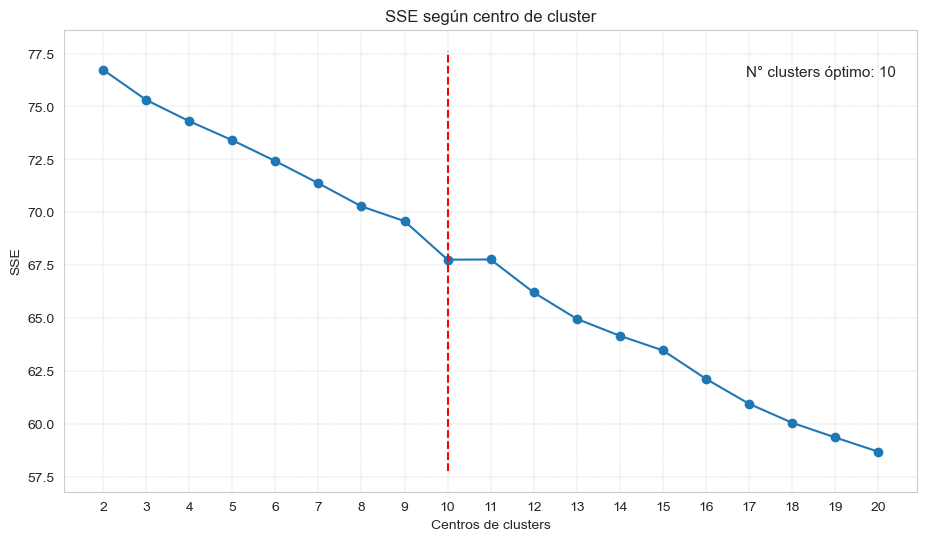

In [41]:
# Clustering | Se determina el número óptimo de clusters por medio de la libreria Kneed (https://github.com/arvkevi/kneed)
iters, sse = func_find_optimal_clusters(tfidf_data, 20)

In [42]:
# A partir del número óptimo generamos la predicción
clusters = MiniBatchKMeans( n_clusters=10, 
                            max_iter=100,
                            init_size=1024, 
                            batch_size=2048, 
                            random_state=42).fit(tfidf_data).fit_predict(tfidf_data)

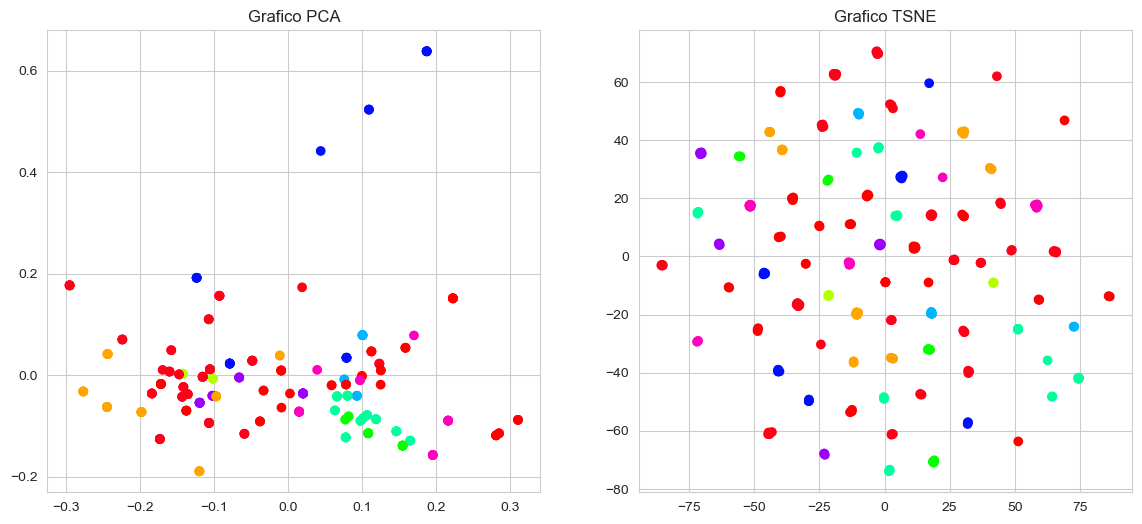

In [43]:
# Resultados para PCA y t-SNE
func_plot_tsne_pca(tfidf_data, clusters)

In [44]:
# Revisando el contenido de los clusters (top 20 palabras)
df_clusters = func_get_top_keywords_cluster(tfidf_data, clusters, tfidf_vect.get_feature_names(), 20)
df_clusters

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
0,social,derecho humanos,hacer,programa,servicio,relativamente,desarrollo,consenso,economico,mas
1,mayor,chile,patria,joven,sector,vialidad urbano,comunidad,cambio,tasa,democracia
2,necesario,militar,gobernante,educacion basico,desarrollo,posible incrementar,acuerdo,abordar,disminucion,hacer
3,congreso,deber ser,proceder,educativo,ano,proyecto,relación,publicar,ultimo,nación
4,pais,democracia,corregir,cobertura,solución,incrementar,vinculo,accion,sector privado,solo
5,materia,profesional,poner,ministerio educacion,ingreso,apoyo eficiente,marco,partido,gasto,ser
6,ser,deber,reclamar,educacional,mas,cooperacion asociacion,europo,tribunal,capacidad productivo,internacional
7,deber,integracion fuerza,discrepar,alumno,mas pobre,sobrepasar,mercado,opinion,privado,mismo
8,recurso,ser,entender,escuela,nivel,sobrepasar barrera,comunidad economico,tal,estabilidad,pueblo
9,laboral,institución,propio,hoy,rural,apoyo,economico europeo,rechazar,disminuir,chileno


**Interpretación**

En primer lugar se concluye que el número óptimo de clusters corresponde a 10, debido a que en ese punto existe un quiebre en el decrecimiento del SSE.

Posteriormente, y ya con los 10 clusters generados, podemos clasificarlos intuitivamente de la siguiente forma (existen algunos clusters más faciles de interpretar que otros): 

* Cluster_1: Servicio social
* Cluster_2: Derechos humanos
* Cluster_3: Gobernar
* Cluster_4: Educacion
* Cluster_5: Pobreza y deuda
* Cluster_6: Apoyo e inversión
* Cluster_7: Desarrollo y acuerdos comerciales
* Cluster_8: Consenso politico
* Cluster_9: Productividad y crecimiento
* Cluster_10: Democracia

### 7.3. Sentiment Analysis + CatBoostRegressor

In [45]:
# Cargamos csv con el lexico afin
lexicon= pd.read_csv('data/lexico_afinn.en.es.csv', sep=',', encoding='latin1')
# lexicon[lexicon['Palabra'].str.contains('felicidad.*')]

print(f'Shape: {lexicon.shape}')
display(lexicon)

Shape: (2476, 3)


,Palabra,Puntuacion,Word;
0,a bordo,1,aboard;
1,abandona,-2,abandons;
2,abandonado,-2,abandoned;
3,abandonar,-2,abandon;
4,abatido,-2,dejected;
...,...,...,...
2471,wowww,4,wowww;
2472,wtf,-4,wtf;
2473,yeees,2,yeees;
2474,culpar,-2,blame;


In [47]:
# Función para extraer la polaridad
def func_sentimient(text):
    '''Función que permite calcular la polaridad promedio a partir de un texto'''
    
    df = lexicon.copy()

    # Cadena unificada de palabras
    lexis=' '.join(df['Palabra'])
    
    # Lista con puntajes
    punct=list(df['Puntuacion'])
    
    # Listas para almacenar palabras y puntaje
    palabra=[]
    puntaje=[]
    p=[]
    
    # Separamos la cadena en cada una de sus palabras
    palabras=text.split()
    pfinal=np.nan
    
    # Ciclo oara obtener el puntaje promedio
    for p in palabras:
        try:
            # Buscamos cada palabra en el lexico
            t=re.search(p,lexis).group()      
            # Almacenamos la palabra en la lista de palabras
            palabra.append(t)
            # Recuperamos el puntaje de la tabla
            p=df[df['Palabra']==t]['Puntuacion'].mean()
            #almacenamos el puntaje en la lista correspondiente
            puntaje.append(p)
            
        except AttributeError:
            continue
            
    # Calculamos la media ignorando eventuales nan
    pfinal=np.nanmean(puntaje)
    
    # Si el resultado es nan, pasamos a ceros
    if np.isnan(pfinal)==True:
        pfinal=np.nan_to_num(pfinal)
    # Si no, manetenemos puntaje
    else:
        pfinal
     
    # Retornamos el puntaje final
    return(pfinal)     

In [48]:
# Añadiendo la polaridad por página
df_polaridad = df_paginas_discurso_preprocessed.copy()

df_polaridad['polaridad'] = df_polaridad['clean_lemma_detok'].apply(lambda x: func_sentimient(x))

print(f'Shape: {df_polaridad.shape}')
display(df_polaridad)

Shape: (81, 8)


,numero_pagina,raw,clean_lemma,clean_lemma_detok,len_raw,len_clean_lemma_detok,len_diff,polaridad
0,1,"1\nLegislatura 320ª, Ordinaria\nSesión del Con...","[legislatura, ordinario, sesion, congreso, ple...",legislatura ordinario sesion congreso pleno lu...,1321,912,409,1.200000
1,2,"2\nDesde hace setenta días, los chilenos vivim...","[hacer, setenta, dia, chileno, vivir, nuevamen...",hacer setenta dia chileno vivir nuevamente baj...,1760,1161,599,-0.080000
2,3,"3\nmenos cierto que esos hechos, cuya frecuenc...","[menos, cierto, hecho, cuyo, frecuencia, dismi...",menos cierto hecho cuyo frecuencia disminuir r...,1622,1123,499,-0.375000
3,4,4\nJusto es reconocer que esta nueva y promiso...,"[justo, reconocer, nuevo, promisorio, realidad...",justo reconocer nuevo promisorio realidad ser ...,1798,1199,599,0.760000
4,5,5\npor diversos partidos políticos coincidenci...,"[diverso, partido, politico, coincidencia, imp...",diverso partido politico coincidencia importan...,1846,1285,561,1.270833
...,...,...,...,...,...,...,...,...
76,77,"77\nSistema Económico Latinoamericano, SELA, d...","[sistema, economico, latinoamericano, selo, di...",sistema economico latinoamericano selo dispone...,1668,1164,504,0.692308
77,78,78\neliminándose “órdenes de mercado” y otras ...,"[eliminar, órden, mercado, medida, proteccioni...",eliminar órden mercado medida proteccionista a...,1818,1270,548,1.470588
78,79,79\nmismo día 11 de marzo hemos reanudado las ...,"[mismo, dia, marzo, reanudado, relación, diplo...",mismo dia marzo reanudado relación diplomatico...,1826,1248,578,1.375000
79,80,"80\nanexos de cada Ministerio, los señores Par...","[anexo, cada, ministerio, senor, parlamentario...",anexo cada ministerio senor parlamentario enco...,1724,1189,535,-0.028736


In [49]:
# EDA polaridad | Estadística descriptiva
df_polaridad['polaridad'].describe()

count    81.000000
mean      0.559489
std       0.753790
min      -1.209677
25%       0.071429
50%       0.607143
75%       1.270833
max       1.791667
Name: polaridad, dtype: float64

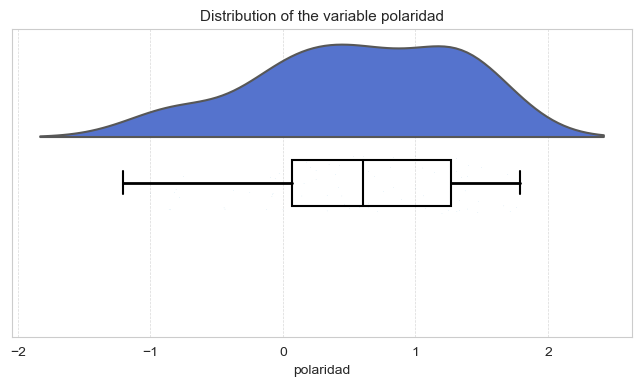

In [50]:
# EDA polaridad | Densidad
func_box_plot(df = df_polaridad, var='polaridad')

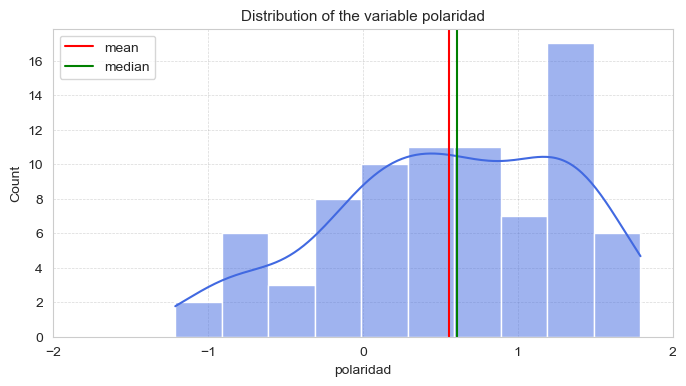

In [51]:
# EDA polaridad | Histograma
func_hist_plot(df=df_polaridad, var_x='polaridad',xticks=range(-2,3,1), bins=10)

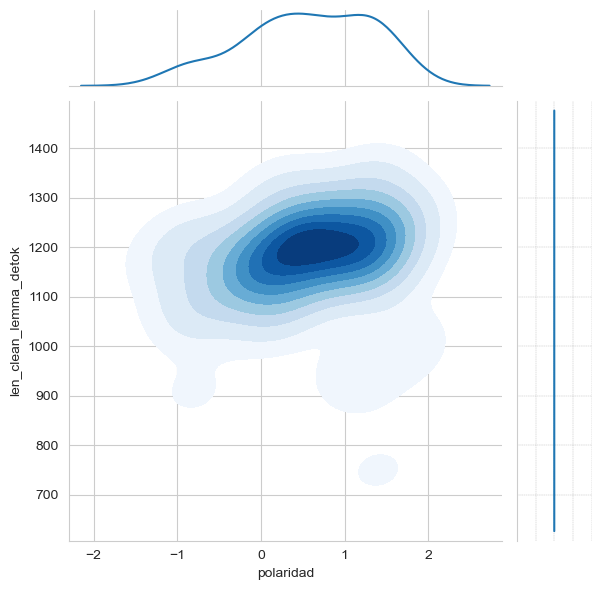

In [52]:
# EDA polaridad | Join plot
sns.jointplot(x=df_polaridad['polaridad'], y=df_polaridad['len_clean_lemma_detok'], cmap="Blues", shade=True, kind='kde')
plt.grid(color='gray', linestyle='--', linewidth=0.3, axis='both', alpha=0.6)
plt.xticks(range(-2,3,1))
plt.show()

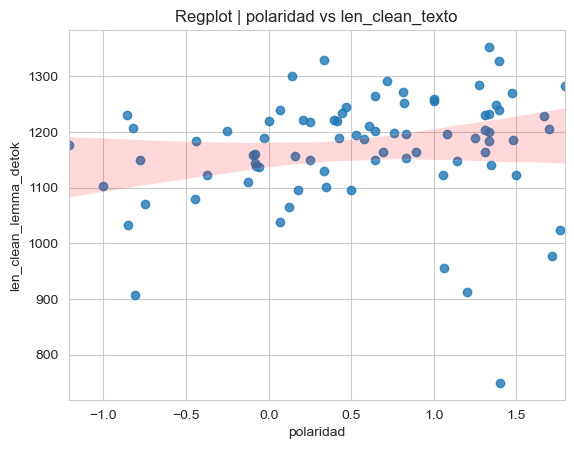

In [53]:
# EDA polaridad | Reg plot
sns.regplot(x=df_polaridad['polaridad'], y=df_polaridad['len_clean_lemma_detok'], line_kws={"color":"r","alpha":0.0,"lw":1})
plt.title('Regplot | polaridad vs len_clean_texto')
plt.show()

#### Predicción (CatBoostRegressor)

In [87]:
# TF-IDF a polaridad
def identity_tokenizer(text):
    return text

# Instance
tfidf_vect_polaridad = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False,
                             use_idf=True,
                             binary=False,
                             ngram_range=(1,2) # unigrams and bigrams
                             ) 

# Fit
tfidf_vect_polaridad.fit(df_polaridad['clean_lemma'])

# Transform
tfidf_data_polaridad = tfidf_vect_polaridad.transform(df_polaridad['clean_lemma'])

# Data frame
df_tfidf_polaridad =pd.DataFrame(tfidf_data_polaridad.toarray(), columns=tfidf_vect_polaridad.get_feature_names())

print(f'Shape: {df_polaridad.shape}')
print(f'Shape: {df_tfidf_polaridad.shape}')
display(df_tfidf_polaridad)

Shape: (81, 8)
Shape: (81, 12663)


,abarcar,abarcar mil,abarcar sector,abastecer,abastecer demanda,abastecimiento,abastecimiento hecho,abierto,abierto chile,abierto desarrollo,...,vuelto democracia,xxi,xxi aportar,yacimiento,yacimiento asi,zona,zona desertico,zona pais,órden,órden mercado
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050095,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067009,0.067009
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.056622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [88]:
# Preparamos las variables dependientes e independientes

## i) Variable dependiente
y = df_polaridad[['polaridad']].copy()

#### Standarizando variable dependiente
mean = y.mean()[0]
std  = y.std()[0]

print(f'Mean: {mean}')
print(f'Std: {std}')

y = (y.astype(float)-mean)/std

## ii) Variables independientes

X = df_tfidf_polaridad

print(f'\nShape y: {y.shape}')
print(f'Shape X: {X.shape}')

Mean: 0.5594888853805934
Std: 0.75379021304442

Shape y: (81, 1)
Shape X: (81, 12663)


In [89]:
# Train-test-split

X_train, X_test, y_train, y_test = train_test_split(  X,
                                                      y,
                                                      test_size=0.3, 
                                                      random_state = 42
                                                   )
print(f'Shape X_train: {X_train.shape}')
print(f'Shape X_train: {X_test.shape}')
print(f'Shape X_train: {y_train.shape}')
print(f'Shape X_train: {y_test.shape}')

Shape X_train: (56, 12663)
Shape X_train: (25, 12663)
Shape X_train: (56, 1)
Shape X_train: (25, 1)


In [90]:
%%time
# Entrenando modelo CatBoostRegressor con parámetros por defecto

train_dataset = Pool(X_train, y_train) 
test_dataset = Pool(X_test, y_test)

model_ctb_basic = CatBoostRegressor(logging_level='Silent') # logging_level='Silent' -> it means no output logs to stdout (except for important warnings) and is same as silent=True or verbose=False
model_ctb_basic.fit(train_dataset)

y_pred = pd.Series(model_ctb_basic.predict(test_dataset))

# Metrics on test data
df_metrics_ctb_basic = func_models_metrics(expected_y=y_test, predicted_y= y_pred, model='Catboost - Basic parameters')
df_metrics_ctb_basic

Wall time: 28.6 s


,model,rmse,r2,mae,mse
0,Catboost - Basic parameters,0.787461,0.278277,0.678672,0.620095


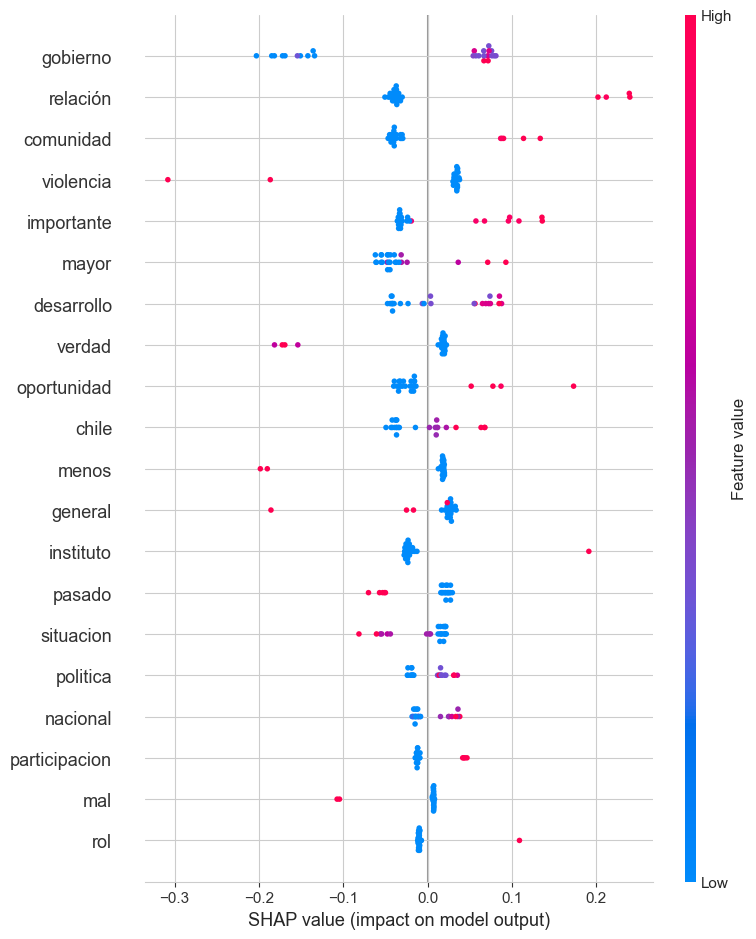

In [91]:
# Feature importance (SHAP)
# Documentacion SHAP: https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30
explainer = shap.TreeExplainer(model_ctb_basic)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
plt.show()

**Interpretación**

En base a los SHAP values se puede ver que los 10 terminos que mayor impactan en la polaridad de un documento (página) en orden ascendente son:

1. gobierno
2. relacion
3. comunidad
4. violencia
5. importante
6. mayor
7. desarrollo
8. verdad
9. oportunidad
10. chile

El gráfico anterior muestra también para que lado se encuentran más cargados ciertos terminos, como por ejemplo el termino "violencia" tiene una polaridad mucho más negativa que el termino "comunidad"


In [94]:
# Feature importance (utilizando la instancia del modelo catboost)
fi = pd.DataFrame(model_ctb_basic.feature_importances_, columns = ["feature_importance"])
fi["variable"] = X.columns.tolist()

fi = fi.sort_values(by=["feature_importance"], ascending = False)

In [95]:
# Top 10 
fi[:10]

,feature_importance,variable
5478,7.505189,gobierno
12568,5.585956,violencia
2143,4.056060,comunidad
12452,3.597269,verdad
7227,3.453958,mayor
5967,3.403850,importante
5394,3.159307,general
10506,2.889988,relación
1675,2.557338,chile
6315,2.431474,instituto


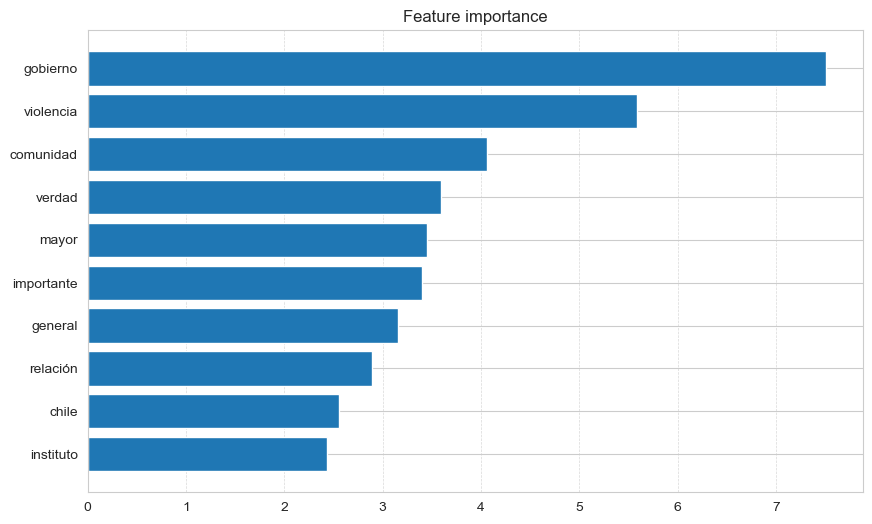

In [110]:
# Graficando el feature importance
plt.figure(figsize=(10, 6))
fi = fi[:10][::-1]
plt.barh(fi[fi["feature_importance"] > 0]["variable"],fi[fi["feature_importance"] > 0]["feature_importance"])
plt.title('Feature importance')
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='x', alpha=0.3)
plt.show()

**Interpretación**

También se puede extraer el feature importance de cada termino utilizando el método ".feature_importances_" de CatBoost donde son similares a los obtenidos por SHAP, teniendo como top 10 a los siguientes terminos (en orden ascendente):

1. gobierno
2. violencia
3. comunidad
4. verdad
5. mayor
6. importante
7. general
8. relación
9. chile
10. instituto